<a href="https://colab.research.google.com/github/ICS-HYEJU/BERT/blob/main/BERT_Pre_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

KoWiki 데이터 셋 처리 하는 방법 ([링크](https://blog.naver.com/goreng2/222484574485))

### Libraries

In [ ]:
!pip install tokenization

In [ ]:
import os
from tqdm import tqdm
import unicodedata
import glob
import copy

import numpy as np
import collections

import tokenization as tokenization

import random
import h5py

import argparse
import json
from tokenizers import BertWordPieceTokenizer
import glob

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import torch
import torch.nn as nn

import math
import torch.nn.functional as F

from typing import Final, Any, Callable
from torch.nn import init

from torch.optim.optimizer import Optimizer
from torch.optim.lr_scheduler import _LRScheduler

from transformers import AdamW

BertAdam vs. Adam [링크](https://velog.io/@jaylnne/NLP-BertAdam-optimizer-%EC%9D%98-%EA%B0%9C%EB%85%90-Adam-%EA%B3%BC%EC%9D%98-%EC%B0%A8%EC%9D%B4%EC%A0%90-%EC%A0%95%EB%A6%AC)

### 1. 위키백과 데이터 추출

* KoWiki Dump: [링크](https://)

#### 1-1. Dump 데이터 받고 압축 풀기

* 아래 내용은 서버 관점에서 생각하면 터미널로 실행해서 데이터들을 받아야 하는 것.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
os.chdir('/content/drive/MyDrive/colab_code_study/Transformer_advanced/dataset/bert/ko_wiki/all')
#
!git clone https://github.com/attardi/wikiextractor.git

fatal: destination path 'wikiextractor' already exists and is not an empty directory.


In [ ]:
os.chdir('/content/drive/MyDrive/colab_code_study/Transformer_advanced/dataset/bert/ko_wiki/all/wikiextractor/wikiextractor')
#
!wget https://dumps.wikimedia.org/kowiki/latest/kowiki-latest-pages-articles.xml.bz2

--2024-05-22 08:31:25--  https://dumps.wikimedia.org/kowiki/latest/kowiki-latest-pages-articles.xml.bz2
Resolving dumps.wikimedia.org (dumps.wikimedia.org)... 208.80.154.71, 2620:0:861:3:208:80:154:71
Connecting to dumps.wikimedia.org (dumps.wikimedia.org)|208.80.154.71|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 818767889 (781M) [application/octet-stream]
Saving to: ‘kowiki-latest-pages-articles.xml.bz2.10’

kowiki-latest-pages 100%[===================>] 780.84M  4.99MB/s    in 2m 38s  

2024-05-22 08:34:04 (4.95 MB/s) - ‘kowiki-latest-pages-articles.xml.bz2.10’ saved [818767889/818767889]



* 아래 코드를 실행하면 상당히 오랜 시간이 걸림.
* 그래서 Preprocessed 1900000 pages 가 뜨고 난 다음에 몇개 파일 추출 후에 중단 하였음.

In [ ]:
os.chdir('/content/drive/MyDrive/colab_code_study/Transformer_advanced/dataset/bert/ko_wiki/all/wikiextractor')
#
!python -m wikiextractor.WikiExtractor kowiki-latest-pages-articles.xml.bz2

INFO: Preprocessing 'kowiki-latest-pages-articles.xml.bz2' to collect template definitions: this may take some time.
Traceback (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/content/drive/.shortcut-targets-by-id/1NX_q1FRVoe10MisxnhXJl8hIxTcJTk33/Transformer_advanced/dataset/bert/ko_wiki/all/wikiextractor/wikiextractor/WikiExtractor.py", line 643, in <module>
    main()
  File "/content/drive/.shortcut-targets-by-id/1NX_q1FRVoe10MisxnhXJl8hIxTcJTk33/Transformer_advanced/dataset/bert/ko_wiki/all/wikiextractor/wikiextractor/WikiExtractor.py", line 639, in main
    process_dump(input_file, args.templates, output_path, file_size,
  File "/content/drive/.shortcut-targets-by-id/1NX_q1FRVoe10MisxnhXJl8hIxTcJTk33/Transformer_advanced/dataset/bert/ko_wiki/all/wikiextractor/wikiextractor/WikiExtractor.py"

#### 1-2. 하나의 파일로 만들기

* 추출 후 조각 나 있는 말뭉치들을 하나의 파일로 만들고 싶다면 아래 내용을 실행

In [ ]:
def wiki_merge(wiki_path, output_file_path='corpus.txt', recursive=False, verbose=False):
    import glob
    #
    with open(output_file_path, mode='w', newline='\n') as ofile:
        for dirname in glob.glob(wiki_path + '/*/', recursive=False):
            num_files_in_dir = len(glob.glob(dirname + 'wiki_*', recursive=recursive))
            for filename in tqdm(glob.glob(dirname + 'wiki_*', recursive=recursive),
                                 total=num_files_in_dir, leave=True, desc="[" + dirname.split('/')[-2] + "]"):
                article_lines = []
                article_open = False

                with open(filename, mode='r', newline='\n') as file:
                    for line in file:
                        if '<doc id=' in line:
                            # <doc id 가 wiki 의 하나의 article 시작을 알림.
                            article_open = True
                        elif '</doc>' in line:
                            # </doc> 가 wiki 의 하나의 article 끝을 의미.
                            article_open = False
                            # 하나의 article 본문을 모은 article_lines 를 파일에다가
                            # write 함.
                            for oline in article_lines[1:]:
                                if oline != '\n':
                                    ofile.write(oline.rstrip() + " ")
                            ofile.write("\n\n")
                            article_lines = []
                        else:
                            # 파일로 부터 한줄을 읽었을 때, <doc id 도 없고 </doc> 이 없으면
                            # 하나의 article 의 본문 내용이므로 append 로 모음.
                            if article_open:
                                article_lines.append(line)
    ofile.close()

In [ ]:
wiki_path = '/content/drive/MyDrive/colab_code_study/Transformer_advanced/dataset/bert/ko_wiki/all/wikiextractor/text/'
#
texts = wiki_merge(wiki_path=wiki_path,
                   output_file_path='corpus.txt')

[AD]:  45%|████▌     | 45/100 [00:02<00:03, 18.20it/s]


KeyboardInterrupt: 

#### 1-3. 데이터 정제

* 아래와 같은 불필요한 데이터를 지워야 함.

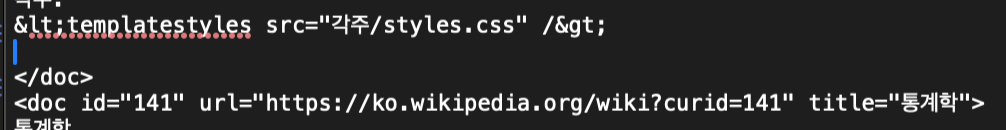

In [ ]:
def data_refine(txt_path):
    f = open(txt_path, 'r')
    num_lines = len(f.readlines())
    #
    text = []
    with open(txt_path, 'r') as f:
        with tqdm(total = num_lines) as pbar:
            while True:
                pbar.update(1)
                #
                line = f.readline()
                #
                if not line: break
                #
                if ('title=' in line) and ('url=' in line) and ('doc id=' in line):
                    continue
                elif ('</doc>' in line):
                    continue
                elif ('&lt;' in line) and ('/&gt'):
                    continue
                elif ('style="text-align' in line):
                    continue
                else:
                    text.append(line)
                # 위 조건들 말고 이상한게 있으면 더 추가하여 제거할 수 있을 것..
    return text

In [ ]:
text_refined = data_refine('corpus.txt')
#
with open('corpus_refined.txt', 'w') as f:
    f.write(''.join(text_refined))

#### 1-4. 사전 작업해놓은거 다운

In [ ]:
os.chdir('/content/')
#
!curl -c ./cookie -s -L "https://drive.google.com/uc?export=download&id=14tDnuNs6_0FAmgC8aL3Nvv32Owcmv9Yj" > /dev/null
!curl -Lb ./cookie "https://drive.google.com/uc?export=download&confirm=`awk '/download/ {print $NF}' ./cookie`&id=1zib1GI8Q5wV08TgYBa2GagqNh4jyfXZz" -o corpus.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1323k  100 1323k    0     0   690k      0  0:00:01  0:00:01 --:--:-- 1490k


#### 1-5. 문서별로 파일 저장

* 보통 관련 정보로 구성되어 있는 것을 문서라고 함.
* 문서 간에는 \n\n 으로 구분되어 있음.

In [ ]:
def split_documents(file_path, save_path):
    document_lines = []
    document_id = 0
    #
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    #
    f = open(file_path, 'r')
    lines = f.readlines()
    for i in range(len(lines)):
        line = lines[i]
        if line == '\n':
            with open(os.path.join(save_path, 'doc_' + str(document_id) + '.txt'), 'w') as ofile:
                for oline in document_lines[0:]:
                    ofile.write(oline)
            ofile.close()
            #
            document_id += 1
            document_lines = []
        else:
            document_lines.append(line)

In [ ]:
# save_path = '/content/drive/MyDrive/colab_code_study/Transformer_advanced/dataset/bert/ko_wiki/all/document/'
save_path = './splitted_documents'
split_documents(file_path='corpus.txt', save_path=save_path)

### 2. Configuration

In [ ]:
# For dataset
random_seed = 12345
max_seq_length = 128
dupe_factor = 10
short_seq_prob = 0.1
masked_lm_prob = 0.15
max_predictions_per_seq = 20
limit_alphabet = 6000
vocab_size = 32000
no_dense_sequence_output = False
#
# Padding for divisibility by 8
if vocab_size % 8 != 0:
    vocab_size += 8 - (vocab_size % 8)
#
dataset_path = './dataset'
input_file = './splitted_documents'
vocab_txt_path = dataset_path + '/vocab.txt'

# For training
device_id = '0'
hidden_size = 768
n_layers_for_encoder = 6
n_attn_heads = 6
model_fp16 = False

lr = 1e-4
warmup_proportion = 1e-2
epochs = 300
max_steps = 1000

batch_size = 16
pin_memory = True
num_workers = 3

gradient_accumulation_steps = 10

### 3. DataObject Class

#### 3-1. Class

In [ ]:
class TrainingInstance_w_IDs(object):
    """A single training instance (sentence pair)."""
    def __init__(self, tokens, tokens_ids,
                 segment_ids, masked_lm_positions, masked_lm_labels,
                 masked_lm_encoded_ids,
                 is_random_next):
        super().__init__()
        self.tokens = tokens
        self.tokens_ids = tokens_ids
        self.segment_ids = segment_ids
        self.is_random_next = is_random_next
        self.masked_lm_positions = masked_lm_positions
        self.masked_lm_labels = masked_lm_labels
        self.masked_lm_encoded_ids = masked_lm_encoded_ids

    def __str__(self):
        s = ""
        s += "tokens: %s\n" % (" ".join([x for x in self.tokens]))
        s += "tokens_ids: %s\n" % (" ".join([x for x in self.tokens_ids]))
        s += "segment_ids: %s\n" % (" ".join([str(x) for x in self.segment_ids]))
        s += "is_random_next: %s\n" % self.is_random_next
        s += "masked_lm_positions: %s\n" % (" ".join(
            [str(x) for x in self.masked_lm_positions]))
        s += "masked_lm_labels: %s\n" % (" ".join(
            [x for x in self.masked_lm_labels]))
        s += "masked_lm_encoded_ids: %s\n" % (" ".join(
            [x for x in self.masked_lm_encoded_ids]))
        s += "\n"
        return s

In [ ]:
class bert_dataset(Dataset):
    def __init__(self, max_seq_length,
                 dupe_factor, short_seq_prob, masked_lm_prob,
                 max_predictions_per_seq, random_seed,
                 input_file, dataset_path, vocab_txt_path,
                 limit_alphabet, vocab_size, mode='train', new_data=True,
                 saved_dataset_path=None,
                 saved_vocab_path=None):
        super().__init__()
        #
        if new_data:
            input_files = self.get_input_files(input_file)
            #
            self.tokenizer, vocab_save_path = self.train_tokenizer(input_files, limit_alphabet,
                                                                   vocab_size, dataset_path)
            #
            self.preprocessing_vocab_txt(vocab_save_path, vocab_txt_path)
            #
            rng = random.Random(random_seed)
            #
            save_data_instances_path = self.make_data_instance(input_files, self.tokenizer, max_seq_length,
                                                              dupe_factor, short_seq_prob, masked_lm_prob,
                                                              max_predictions_per_seq, rng, vocab_txt_path,
                                                              dataset_path, mode)
            #
            self.instances = self.load_saved_training_instance(save_data_instances_path)
        else:
            assert saved_dataset_path is not None, 'saved_dataset_path is needed!'
            assert saved_vocab_path is not None, 'saved_vocab_path is needed!'
            #
            self.tokenizer = self.load_tokenizer(saved_vocab_path)
            #
            self.instances = self.load_saved_training_instance(saved_dataset_path)
            #
            assert len(self.instances) > 0, 'Invalid saved_dataset_path...'

    def __len__(self):
        return len(self.instances["input_ids"])

    def __getitem__(self, index):
        data = collections.OrderedDict()
        #
        data["input_ids"] = self.instances["input_ids"][index]
        data["input_mask"] = self.instances["input_mask"][index]
        data["segment_ids"] = self.instances["segment_ids"][index]
        data["masked_lm_positions"] = self.instances["masked_lm_positions"][index]
        data["masked_lm_ids"] = self.instances["masked_lm_ids"][index]
        data["next_sentence_labels"] = self.instances["next_sentence_labels"][index]
        #
        return data

    @staticmethod
    def get_input_files(input_file):
        print("="*30)
        print("[Input Files] Getting input file paths...")
        print("="*30)

        input_files = []
        #
        if os.path.isfile(input_file):
          input_files.append(input_file)
        elif os.path.isdir(input_file):
          input_files = [os.path.join(input_file, f) for f in os.listdir(input_file) if (os.path.isfile(os.path.join(input_file, f)) and f.endswith('.txt') )]
        else:
          raise ValueError("{} is not a valid path".format(input_file))
        #
        return input_files

    @staticmethod
    def load_tokenizer(saved_vocab_path):
        print("="*30)
        print("[SubTokenizer] Loading BERT-Tokenizer, {}".format(saved_vocab_path))
        #
        wordpieces_prefix = "##"
        tokenizer = BertWordPieceTokenizer(
            vocab=saved_vocab_path,
            clean_text=True,
            handle_chinese_chars=True,
            strip_accents=False,
            lowercase=False,
            wordpieces_prefix=wordpieces_prefix)
        print("="*30)
        return tokenizer

    @staticmethod
    def train_tokenizer(input_files, limit_alphabet, vocab_size, dataset_path):
        print("="*30)
        print("[SubTokenizer] Training BERT-Tokenizer with WordPieceSubTokenizer")
        #
        wordpieces_prefix = "##"
        #
        tokenizer = BertWordPieceTokenizer(
            vocab=None,
            clean_text=True,
            handle_chinese_chars=True,
            strip_accents=False,
            lowercase=False,
            wordpieces_prefix=wordpieces_prefix)
        #
        tokenizer.train(input_files,
                        limit_alphabet=limit_alphabet, vocab_size=vocab_size,
                        wordpieces_prefix=wordpieces_prefix,
                        show_progress=True)
        #
        if not os.path.exists(dataset_path):
            os.makedirs(dataset_path)
        #
        save_path = os.path.join(dataset_path, "ch-{}-wpm-{}-pretty".format(limit_alphabet, vocab_size))
        print("Save Trained Tokenizer... {}".format(save_path))
        print("="*30)
        tokenizer.save(save_path, True)
        #
        return tokenizer, save_path

    @staticmethod
    def preprocessing_vocab_txt(vocab_save_path, vocab_txt_save_path):
        print("="*30)
        print("[Preprocessing vocab.txt] Preprocessing...")

        bert_dataset.make_vocab_txt(vocab_path = vocab_save_path,
                                    vocab_txt_save_path = vocab_txt_save_path)
        print("="*30)

    @staticmethod
    def make_data_instance(input_files, tokenizer, max_seq_length,
                           dupe_factor, short_seq_prob, masked_lm_prob,
                           max_predictions_per_seq, rng, vocab_txt_path,
                           dataset_path, mode):
        #
        instances = bert_dataset.create_training_instances_w_ids(
            input_files, tokenizer, max_seq_length, dupe_factor,
            short_seq_prob, masked_lm_prob, max_predictions_per_seq,
            rng, vocab_txt_path)
        #
        save_data_instances_path = os.path.join(dataset_path, mode + '_instances')
        #
        bert_dataset.write_instance_to_example_file(instances,
                                                    max_seq_length,
                                                    max_predictions_per_seq,
                                                    output_file=save_data_instances_path)
        return save_data_instances_path

    @staticmethod
    def load_saved_training_instance(save_path):
        features = collections.OrderedDict()

        print("="*30)
        print("[Loading Training Instances] {}".format(save_path))

        with h5py.File(save_path, 'r') as f:
          features["input_ids"] = f['input_ids'][:]
          features["input_mask"] = f['input_mask'][:]
          features["segment_ids"] = f['segment_ids'][:]
          features["masked_lm_positions"] = f['masked_lm_positions'][:]
          features["masked_lm_ids"] = f['masked_lm_ids'][:]
          features["next_sentence_labels"] = f['next_sentence_labels'][:]
        f.close()

        print("Total Loaded Data: {}".format(len(features["input_ids"])))
        print("="*30)
        return features

    @staticmethod
    def create_training_instances_w_ids(input_files, tokenizer, max_seq_length,
                                        dupe_factor, short_seq_prob, masked_lm_prob,
                                        max_predictions_per_seq, rng, vocab_txt_path):
        """Create `TrainingInstance`s from raw text."""
        print("="*30)
        print("[Creating Training Instances]")

        all_documents = [[]]
        all_documents_ids = [[]]

        for input_file in sorted(input_files):
          # print("creating instance from {}".format(input_file))
          with open(input_file, "r") as reader:
            while True:
              line = reader.readline()
              line = line.strip()

              # Empty lines are used as document delimiters
              if not line:
                all_documents.append([])
                all_documents_ids.append([])
                break
              encoded = tokenizer.encode(line)
              tokens = encoded.tokens
              ids = encoded.ids
              if tokens:
                all_documents[-1].append(tokens)
                all_documents_ids[-1].append(ids)

          # Remove empty documents
          all_documents_ = []
          all_documents_ids_ = []
          idx = 0
          for x in all_documents:
            if x:
              all_documents_.append(x)
              all_documents_ids_.append(all_documents_ids[idx])
            idx += 1

        vocab_words = list(map(lambda x : x.rstrip(),
                              open(vocab_txt_path, 'r').readlines()))[5:]
        special_ids = {"[PAD]": 0, "[UNK]": 1, "[CLS]": 2, "[SEP]": 3, "[MASK]": 4}

        instances = []
        for _ in range(dupe_factor):
          for document_index in range(len(all_documents_)):
            instances.extend(
                bert_dataset.create_instances_from_document_w_ids(
                    all_documents_, all_documents_ids_, document_index, max_seq_length, short_seq_prob,
                    masked_lm_prob, max_predictions_per_seq, vocab_words, rng,
                    special_ids))

        rng.shuffle(instances)

        print("Total Instances: ", len(instances))
        print("="*30)

        return instances

    @staticmethod
    def create_instances_from_document_w_ids(
      all_documents, all_documents_ids, document_index, max_seq_length, short_seq_prob,
      masked_lm_prob, max_predictions_per_seq, vocab_words, rng,
      special_ids = {"[PAD]": 0, "[UNK]": 1, "[CLS]": 2, "[SEP]": 3, "[MASK]": 4}):

      """Creates `TrainingInstance`s for a single document."""
      document = all_documents[document_index]
      document_ids = all_documents_ids[document_index]

      # Account for [CLS], [SEP], [SEP]
      max_num_tokens = max_seq_length - 3

      # We *usually* want to fill up the entire sequence since we are padding
      # to `max_seq_length` anyways, so short sequences are generally wasted
      # computation. However, we *sometimes*
      # (i.e., short_seq_prob == 0.1 == 10% of the time) want to use shorter
      # sequences to minimize the mismatch between pre-training and fine-tuning.
      # The `target_seq_length` is just a rough target however, whereas
      # `max_seq_length` is a hard limit.
      target_seq_length = max_num_tokens
      if rng.random() < short_seq_prob:
        target_seq_length = rng.randint(2, max_num_tokens)

      # We DON'T just concatenate all of the tokens from a document into a long
      # sequence and choose an arbitrary split point because this would make the
      # next sentence prediction task too easy. Instead, we split the input into
      # segments "A" and "B" based on the actual "sentences" provided by the user
      # input.
      instances = []
      current_chunk = []
      current_chunk_ids = []
      #
      current_length = 0
      #
      i = 0
      while i < len(document):
        segment = document[i]
        seg_id = document_ids[i]
        #
        assert len(segment) == len(seg_id)
        #
        current_chunk.append(segment)
        current_chunk_ids.append(seg_id)
        #
        assert len(current_chunk) == len(current_chunk_ids)
        #
        current_length += len(segment)
        #
        if (i == len(document) - 1 or current_length >= target_seq_length) and len(current_chunk) >= 2:
          if current_chunk:
            # `a_end` is how many segments from `current_chunk` go into the `A`
            # (first) sentence.
            a_end = 1
            if len(current_chunk) >= 2:
              a_end = rng.randint(1, len(current_chunk) - 1)

            tokens_a = []
            tokens_a_ids = []
            for j in range(a_end):
              tokens_a.extend(current_chunk[j])
              tokens_a_ids.extend(current_chunk_ids[j])

            tokens_b = []
            tokens_b_ids = []
            # Random next
            is_random_next = False
            if len(current_chunk) == 1 or rng.random() < 0.5:
              is_random_next = True
              target_b_length = target_seq_length - len(tokens_a)

              # This should rarely go for more than one iteration for large
              # corpora. However, just to be careful, we try to make sure that
              # the random document is not the same as the document
              # we're processing.
              for _ in range(10):
                random_document_index = rng.randint(0, len(all_documents) - 1)
                if random_document_index != document_index:
                  break

              #If picked random document is the same as the current document
              if random_document_index == document_index:
                is_random_next = False

              random_document = all_documents[random_document_index]
              random_document_ids = all_documents_ids[random_document_index]
              #
              random_start = rng.randint(0, len(random_document) - 1)
              for j in range(random_start, len(random_document)):
                tokens_b.extend(random_document[j])
                tokens_b_ids.extend(random_document_ids[j])
                if len(tokens_b) >= target_b_length:
                  break
              # We didn't actually use these segments so we "put them back" so
              # they don't go to waste.
              num_unused_segments = len(current_chunk) - a_end
              i -= num_unused_segments
            # Actual next
            else:
              is_random_next = False
              for j in range(a_end, len(current_chunk)):
                tokens_b.extend(current_chunk[j])
                tokens_b_ids.extend(current_chunk_ids[j])

            assert len(tokens_a) == len(tokens_a_ids)
            assert len(tokens_b) == len(tokens_b_ids)
            #
            bert_dataset.truncate_seq_pair_w_ids(tokens_a, tokens_b, tokens_a_ids, tokens_b_ids, max_num_tokens, rng)

            assert len(tokens_a) >= 1
            assert len(tokens_b) >= 1
            assert len(tokens_a) == len(tokens_a_ids)
            assert len(tokens_b) == len(tokens_b_ids)

            tokens = []
            tokens_ids = []
            segment_ids = []
            #
            tokens.append("[CLS]")
            tokens_ids.append(special_ids["[CLS]"])
            segment_ids.append(0)
            for token in tokens_a:
              tokens.append(token)
              segment_ids.append(0)
            for token_id in tokens_a_ids:
              tokens_ids.append(token_id)

            tokens.append("[SEP]")
            tokens_ids.append(special_ids["[SEP]"])
            segment_ids.append(0)
            for token in tokens_b:
              tokens.append(token)
              segment_ids.append(1)
            for token_id in tokens_b_ids:
              tokens_ids.append(token_id)

            tokens.append("[SEP]")
            tokens_ids.append(special_ids["[SEP]"])
            segment_ids.append(1)

            assert len(tokens) == len(tokens_ids)
            assert len(tokens) == len(segment_ids)

            (tokens, tokens_ids, masked_lm_positions,
            masked_lm_labels, masked_lm_encoded_ids) = bert_dataset.create_masked_lm_predictions_w_ids(
                tokens, tokens_ids, masked_lm_prob, max_predictions_per_seq, vocab_words, rng,
                special_ids)
            instance = TrainingInstance_w_IDs(
                tokens=tokens,
                tokens_ids=tokens_ids,
                segment_ids=segment_ids,
                is_random_next=is_random_next,
                masked_lm_positions=masked_lm_positions,
                masked_lm_labels=masked_lm_labels,
                masked_lm_encoded_ids=masked_lm_encoded_ids)
            instances.append(instance)

          current_chunk = []
          current_chunk_ids = []
          current_length = 0
        i += 1
      return instances

    @staticmethod
    def create_masked_lm_predictions_w_ids(tokens,
                                       tokens_ids,
                                       masked_lm_prob, max_predictions_per_seq,
                                       vocab_words, rng,
                                       special_ids):
        """Creates the predictions for the masked LM objective."""
        """
          - max_predictions_per_seq: [MASK] 할 최대 Tokens 수
          - masked_lm_prob: Token 하나당 [MASK] 될 확률
          - vocab_words: vocab.txt 안의 vocabulary 들 (special tokens 들은 제외)
        """

        MaskedLmInstance = collections.namedtuple(
            "MaskedLmInstance", ["index", "label", "encoded_ids"]
            )

        # ---- MASKING 할 수 있는 Tokens 의 index 들을 Collect
        cand_indexes = []
        for (i, token) in enumerate(tokens):
            if token == "[CLS]" or token == "[SEP]":  # [CLS], [SEP]는 마스킹 후보에서 제외
                continue
            cand_indexes.append(i)
        rng.shuffle(cand_indexes)

        # ---- 몇개를 마스킹 할 것인지 결정 ----
        #   1) 토큰 개수 * masked_lm_prob (masked_lm_prob=0.15 -> 약 20개)
        #   2) max_predictions_per_seq
        # 위 1) 과 2) 중 더 작은 수 만큼 마스킹 함.
        num_to_predict = min(max_predictions_per_seq,
                            max(1, int(round(len(tokens) * masked_lm_prob)))
                            )

        # ---- 마스킹할 Tokens 결정 ----
        masked_lms = []  # 마스킹 된 토큰 객체 (인덱스와 라벨이 포함되어있다)
        covered_indexes = set()  # 마스킹할 토큰의 인덱스

        output_tokens = list(tokens)
        output_tokens_ids = list(tokens_ids)
        for index in cand_indexes:
            if len(masked_lms) >= num_to_predict:  # 목표치 채웠으면 끝내고
                break
            if index in covered_indexes:  # 이미 마스킹된 index 면 건너뛰기
                continue
            # 해당 Index 마스킹 할 것이다.
            covered_indexes.add(index)

            # 80% of the time, replace with [MASK]
            if rng.random() < 0.8:
                # 0.8의 확률로 마스킹
                masked_token = "[MASK]"
                masked_token_ids = special_ids["[MASK]"]
            else:
                if rng.random() < 0.5:
                    # 0.1의 확률로 그대로
                    masked_token = tokens[index]
                    masked_token_ids = tokens_ids[index]
                else:
                    # 0.1의 확률로 랜덤 토큰
                    masked_token_ids = rng.randint(0, len(vocab_words) - 1)
                    masked_token = vocab_words[masked_token_ids]

            # ---- 마스킹된 토큰으로 교체 ----
            output_tokens[index] = masked_token
            output_tokens_ids[index] = masked_token_ids

            # ---- 마스킹한 토큰의 인덱스와 라벨 저장 ----
            masked_lms.append(
                MaskedLmInstance(
                    index=index,
                    label=tokens[index],
                    encoded_ids=tokens_ids[index])
                )

        masked_lms = sorted(masked_lms, key=lambda x: x.index)  # Index 로 정렬

        masked_lm_positions = []
        masked_lm_labels = []
        masked_lm_encoded_ids = []

        for p in masked_lms:
            masked_lm_positions.append(p.index)  # 마스킹한 토큰의 인덱스 저장
            masked_lm_labels.append(p.label)  # 마스킹한 토큰의 라 저장
            masked_lm_encoded_ids.append(p.encoded_ids)

        assert len(masked_lm_positions) == len(masked_lm_labels)
        assert len(masked_lm_positions) == len(masked_lm_encoded_ids)

        # (전체 토큰들 - 마스킹 반영, 마스킹 된 토큰의 위치, 마스킹된 토큰의 라벨)
        return output_tokens, output_tokens_ids, masked_lm_positions, masked_lm_labels, masked_lm_encoded_ids

    @staticmethod
    def truncate_seq_pair_w_ids(tokens_a, tokens_b, tokens_a_ids, tokens_b_ids, max_num_tokens, rng):
        """Truncates a pair of sequences to a maximum sequence length."""
        while True:
          total_length = len(tokens_a) + len(tokens_b)
          if total_length <= max_num_tokens:
            break

          trunc_tokens = tokens_a if len(tokens_a) > len(tokens_b) else tokens_b
          trunc_tokens_ids = tokens_a_ids if len(tokens_a) > len(tokens_b) else tokens_b_ids

          assert len(trunc_tokens) >= 1

          # We want to sometimes truncate from the front and sometimes from the
          # back to add more randomness and avoid biases.
          if rng.random() < 0.5:
            del trunc_tokens[0]
            del trunc_tokens_ids[0]
          else:
            trunc_tokens.pop()
            trunc_tokens_ids.pop()

    @staticmethod
    def write_instance_to_example_file(instances, max_seq_length,
                                       max_predictions_per_seq, output_file):
        """Create TF example files from `TrainingInstance`s."""
        print("="*30)
        print("[Saving Training Instances]")

        total_written = 0

        features = collections.OrderedDict()

        num_instances = len(instances)
        features["input_ids"] = np.zeros([num_instances, max_seq_length], dtype="int32")
        features["input_mask"] = np.zeros([num_instances, max_seq_length], dtype="int32")
        features["segment_ids"] = np.zeros([num_instances, max_seq_length], dtype="int32")
        features["masked_lm_positions"] =  np.zeros([num_instances, max_predictions_per_seq], dtype="int32")
        features["masked_lm_ids"] = np.zeros([num_instances, max_predictions_per_seq], dtype="int32")
        features["next_sentence_labels"] = np.zeros(num_instances, dtype="int32")

        for inst_index, instance in enumerate(tqdm(instances)):
          input_ids = instance.tokens_ids
          input_mask = [1] * len(input_ids)
          segment_ids = instance.segment_ids
          assert len(input_ids) <= max_seq_length
          assert len(input_ids) == len(segment_ids)

          while len(input_ids) < max_seq_length:
            input_ids.append(0)
            input_mask.append(0)
            segment_ids.append(0)

          assert len(input_ids) == max_seq_length
          assert len(input_mask) == max_seq_length
          assert len(segment_ids) == max_seq_length

          masked_lm_positions = list(instance.masked_lm_positions)
          masked_lm_ids = instance.masked_lm_encoded_ids
          masked_lm_weights = [1.0] * len(masked_lm_ids)

          while len(masked_lm_positions) < max_predictions_per_seq:
            masked_lm_positions.append(0)
            masked_lm_ids.append(0)
            masked_lm_weights.append(0.0)

          assert len(masked_lm_ids) == max_predictions_per_seq, '{}'.format(len(masked_lm_ids))
          assert len(masked_lm_positions) == max_predictions_per_seq, '{}'.format(len(masked_lm_positions))

          next_sentence_label = 1 if instance.is_random_next else 0

          features["input_ids"][inst_index] = input_ids
          features["input_mask"][inst_index] = input_mask
          features["segment_ids"][inst_index] = segment_ids
          features["masked_lm_positions"][inst_index] = masked_lm_positions
          features["masked_lm_ids"][inst_index] = masked_lm_ids
          features["next_sentence_labels"][inst_index] = next_sentence_label

          total_written += 1

        print("saving data")
        f= h5py.File(output_file, 'w')
        f.create_dataset("input_ids", data=features["input_ids"], dtype='i4', compression='gzip')
        f.create_dataset("input_mask", data=features["input_mask"], dtype='i1', compression='gzip')
        f.create_dataset("segment_ids", data=features["segment_ids"], dtype='i1', compression='gzip')
        f.create_dataset("masked_lm_positions", data=features["masked_lm_positions"], dtype='i4', compression='gzip')
        f.create_dataset("masked_lm_ids", data=features["masked_lm_ids"], dtype='i4', compression='gzip')
        f.create_dataset("next_sentence_labels", data=features["next_sentence_labels"], dtype='i1', compression='gzip')
        f.flush()
        f.close()
        print("="*30)

    @staticmethod
    def make_vocab_txt(vocab_path, vocab_txt_save_path):
        # 생성된 vocab 파일 전처리
        f = open(vocab_txt_save_path, 'w', encoding='utf-8')
        #
        with open(vocab_path) as json_file:
            json_data = json.load(json_file)
            for item in json_data["model"]["vocab"].keys():
                f.write(item+'\n')
            f.close()
        print("Save vocab txt file {}".format(vocab_txt_save_path))

#### Test

In [ ]:
dataset_object = bert_dataset(max_seq_length,
                              dupe_factor, short_seq_prob, masked_lm_prob,
                              max_predictions_per_seq, random_seed,
                              input_file, dataset_path, vocab_txt_path,
                              limit_alphabet, vocab_size, mode='train',
                              new_data=True)

[Input Files] Getting input file paths...
[SubTokenizer] Training BERT-Tokenizer with WordPieceSubTokenizer
Save Trained Tokenizer... ./dataset/ch-6000-wpm-32000-pretty
[Preprocessing vocab.txt] Preprocessing...
Save vocab txt file ./dataset/vocab.txt
[Creating Training Instances]
Total Instances:  20881
[Saving Training Instances]


100%|██████████| 20881/20881 [00:00<00:00, 41498.27it/s]


saving data
[Loading Training Instances] ./dataset/train_instances
Total Loaded Data: 20881


In [ ]:
train_dataloader = DataLoader(dataset_object, batch_size=64, shuffle=True)

for batch_id, data in enumerate(train_dataloader):
    print("[input_ids]: ", list(data["input_ids"][0].numpy()))
    # 코드 정리하기#
    a = list(data["input_ids"][0].numpy())
    masked = []
    for i in a:
        if i == 4: masked.append(i)
    print(len(masked))
    ####################
    print("[Decoded]: ", dataset_object.tokenizer.decode(list(data["input_ids"][0].numpy()), skip_special_tokens=False))
    print("[input_ids, len]: ", len(data["input_ids"][0]))
    print("[input_mask]: ", list(data["input_mask"][0].numpy()))
    print("[segment_ids]: ", list(data["segment_ids"][0].numpy()))
    print("[masked_lm_positions]: ", list(data["masked_lm_positions"][0].numpy()))                  #(bs, 20) : 20 ≈ [len(input_ids) * 0.15 = 19.2] (Mask token은 훈련 토큰의 15%)
    print("[masked_lm_positions.shape]: ", list(data["masked_lm_positions"].numpy().shape))
    print("[masked_lm_ids]: ", list(data["masked_lm_ids"][0].numpy()))
    print("[next_sentence_labels]: ", data["next_sentence_labels"][0].numpy())
    break

[input_ids]:  [2, 4, 68, 5082, 8707, 7334, 11978, 3301, 4576, 15, 8717, 4, 24352, 17, 3, 1609, 8031, 2362, 4, 4, 12049, 4, 1805, 12119, 14784, 8882, 1733, 1870, 2840, 15, 18554, 13543, 21112, 2702, 11891, 1558, 4, 1562, 10, 2801, 2928, 10, 1113, 1006, 1736, 8379, 1658, 4, 48, 4290, 7744, 12329, 8621, 7991, 9187, 1804, 4, 688, 3512, 20199, 10994, 19911, 17, 4225, 1625, 1897, 2859, 16589, 1579, 2745, 4323, 2786, 2695, 3840, 3897, 1574, 4, 6936, 6, 42, 3959, 12341, 6827, 13527, 42, 13102, 15377, 6, 610, 20215, 3157, 19483, 2712, 17, 4, 4, 4, 4, 2721, 2719, 10351, 3678, 17045, 3409, 1579, 13058, 17, 5701, 4727, 5788, 14283, 15, 1246, 4705, 1689, 3535, 5433, 4, 2979, 24241, 19764, 4, 2848, 2817, 1743, 15041, 5742, 3]
15
[Decoded]:  [CLS] [MASK] a이스 슈워제네거는 오스트리아 태생의 미국의 배우, 보디빌더 [MASK] 정치인이다. [SEP]를 그만둔 [MASK] [MASK] 호프 [MASK]태터가 컬럼을 물려받았는데, 마틴 가드너에 대한 존경의 [MASK]서 ' 수학 게임 ' 의 애너그램인 [MASK] Metamagical Themas [MASK] 를 자신의 컬럼 제목으로 정하였다. 1993년이래 그의 유희수학에 대해 관심을 같이하는 사람들이 부정기 [MASK] 모여 " Gatherin

###4. PretrainingBERT Class

####4-1. Implementation of BERT



*   BERT는 Transformer ("Attention is All You Need") 의 Encoder를 이용하여 layer 를 쌓음

*   따라서, Transforemer의 구조와 연산 코드부터 작성.




##### 4-1-1. Embedding


nn.Embedding( )


* **nn.Embedding(num_embeddings, embedding_dim)**    : **init**   
 : == embedding layer 형성  
 : lookup Table 형성 = [num_embeddings, embedding_dim] matrix 형성              

* **Embedding(Input)**      : **forward**  
 : Input은 정수 인덱스 형태의 단어집합  
 : output은 각 단어에 대한 임베딩 벡터 = lookup table에서 각 단어에 해당하는 한 행  
 : lookup table의 값들은 훈련과정에서 update (like 가중치 학습)        
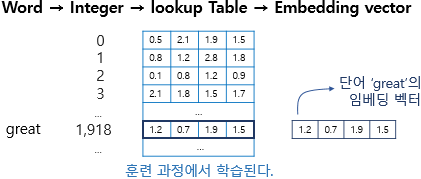
* *forward 연산 시*   
 : 임베딩 파라미터를 선언한 후 forward 메소드를 수행하면 [입력벡터, 임베딩 차원] 크기를 가진 텐서가 출력됨.

 : forward 입력텐서 = 임베딩 벡터를 추출할 범주의 인덱스에 해당하므로 무조건 정수타입(torch.LongTensor)이 들어가야함    
 : ex) nn.Embedding(10,3)  선언 후 forward메소드에 (2,4) 크기의 텐서가 입력으로 들어가면 (2,4,3) = [입력벡터(2,4), 임베딩 차원(3)]크기의 텐서가 출력됨.

* Similar to nn.Linear()   
   : init에서 hidden_layer = linear(input_dim, hidden_dim)  
   : forward 에서 output = hidden_layer(input)


Description



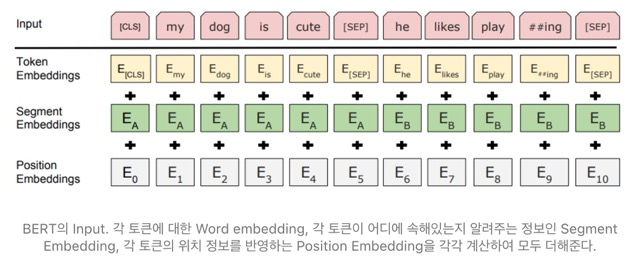
*   Embedding Vector = Dropout(Nomralize(Word Embedding + Position Embedding + Token Type Embedding))
  
  * 아래 내용에서 size의 8은 batch size
  * 아래 Embedding을 위해서 torch.nn.Embedding을 사용
     
     * num_embeddings : embedding vector의 총 갯수
     * embedding_dim : 각 embedding vector의 dimension
     * 예를 들어 num_embeddings = 32000, embedding_dim = 768 이라하자

        * 해당 경우, nn.Embedding에는 32000 수 만큼의 embedding vectors들이 있고 각 vector들은 768의 크기를 가짐.
        * 하나의 스칼라 값이 들어오면 해당 스칼라 값에 대한 32000개의 vectors들 중 하나를 선택하여 출력.

  * **Word Embdding**(Layer) : Word Index Scalar -> Embedding Vector
     * 아래 예제는 vocab_size = 32000라고 생각하면 됨.
     * 토큰의 Index (BERT의 경우 0이상 32199이하의 정수)가 768의 길이인 Vector로 바뀌는 Embedding.
          * 즉, 스칼라를 벡터로 변환
          * torch.Size([8,128]) -> torch.Size([8, 128, 768])
    * 즉, 스칼라가 One-hot Vector로 바뀌고, 길이가 768인 Vector로 전환
    * 이 경우,
        * num_embeddings = vocab_size(32000), embedding_dim = 768

  *  **Position Embedding**(Layer) : Position Index Scalar -> Embedding Vector
     * BERT의 Input에는 해당 토큰의 위치가 어디인지에 대한 정보가 없음.
     * 문장을 해석할 때 단어 위치는 굉장히 중요한 지표
     * 위 예시에서 Position Index Scalar는 0~127사이의 스칼라 값을 가질 것.
         * torch.size([8,128]) -> torch.Size([8, 128, 768])
     * 이 경우,
         * num_embdding = seq_len(128), embedding_dim = 768이 됨.
  * **Token Type Embedding**: Token Type Scalar -> Embedding Vector
     * 여기서 토큰 타입이랑 해당 토큰이 seq_A에 속하는 지, seq_B에 속하는 지에 대한 정보
     * A에 속하면 0, B는 1의 값을 가짐
     * 따라서 이 또한 스칼라에서 벡터로 Embedding 필요
       * torch.Size([8,128]) -> torch.Size([8,128,768])
     * 이 경우,
       * num_embeddings는 token_type_ids(2)이 되고 embddings_dim 은 768이 됨.
  
   



* 여기서 중요한 것은 **세 Embedding 모두 Layer**라는 것
  * 즉, BERT Model이 학습할 때 Embedding 역시 학습 대상이라는 것
  * Pytorch에서는 torch.nn.Embedding 모듈을 사용
      * torch.nn.Embedding의 모델 구조는 FFNN(Fully Conneted)


code

In [ ]:
class BertEmbeddings(nn.Module):
    """
        Construct the embeddings from word, position and token_type embeddings
    """
    def __init__(self, vocab_size, embed_size, max_seq_len, type_vocab_size=2, hidden_dropout_prob=0.1):
        super(BertEmbeddings, self).__init__()                                                                                              # == [super().__init__()]

        # word_embedding = word Index Scalar -> One-hot Vector, len(Vector)= embedding_dim =768
        # 각 단어별 index 가지므로 num_embedding = vocab_size = 32000
        self.word_embeddings = nn.Embedding(num_embeddings=vocab_size,
                                                                         embedding_dim=embed_size)      # (32000,768)
        # position_embedding = Position Index -> embedding Vector
        # 각 단어별 위치 정보를 포함해야하므로 num_embedding = max_seq_len =768
        self.position_embeddings = nn.Embedding(num_embeddings=max_seq_len,
                                                                              embedding_dim=embed_size)    # (128, 768)
        # token_type_embedding = Token type Scalar -> embedding Vector
        # 각 단어별 소속된 문장 (A=0, B=1)정보를 포함해야하므로 num_embeddings = type_vocab_size = 2
        self.token_type_embeddings = nn.Embedding(num_embeddings=type_vocab_size,
                                                                                embedding_dim=embed_size)  # (2, 768)
        self.LayerNorm = nn.LayerNorm(embed_size, eps=1e-12)
        self.dropout = nn.Dropout(hidden_dropout_prob)  # 0.1

    def forward(self, input_ids, token_type_ids):
        seq_length = input_ids.size(1)           # 128

        # 세 Emebedding은 모두 Layer
        # embeddings의 각 행들은 단어 하나를 의미, 행에 존재하는 값들은 각 특성에 대한 weight값 가짐

        # ---- position embedding ----
        #
        # position embedding은 각 단어별 위치값을 나타내는 embedding vector
        # 해당 예제는 max_seq_length = 128이므로 0-127의 index값을 가짐
        # 한 단어는 하나의 행에 해당, 따라서 각 행별 [0,1,2 ....127]의 값을 가진 tensor를 생성해야함
        #
        position_ids = torch.arange(seq_length, dtype=torch.long, device=input_ids.device)       # torch.size([128]), 값이 0-127로 채워짐 / torch.arnage : 1차원 텐서 반환
        position_ids = position_ids.unsqueeze(0).expand_as(input_ids)                                       # torch.Size([64, 128]), 각 행이 [0,1,2, …,127]로 구성되며 행의 수는 64
        #
        position_embeddings = self.position_embeddings(position_ids)                                       # seq_len = 128이므로 각 행별 0-127에 해당하는 index값을 가진 tensor를 position embedding의 input으로 넣어줌

        # ---- words embedding -----
        # 입력벡터 input_ids.size() = [64,128]
        # self.word_embeddings는 768의 임베딩 차원을 가지므로
        # word_embeddings.shape = [64,128,768] = [입력벡터, 임베딩 차원]
        word_embeddings = self.word_embeddings(input_ids)

        # ---- token embedding -----
        # 입력벡터 tokey_type_ids.size() = [64,128]
        # self.token_type_embeddings의 embedding_dim = 768
        # token_type_embeddings.shape = [64,128,768]
        token_type_embeddings = self.token_type_embeddings(token_type_ids)

        embeddings = word_embeddings + position_embeddings + token_type_embeddings
        embeddings = self.LayerNorm(embeddings)
        embeddings = self.dropout(embeddings)

        return embeddings

Test

Q) Transformer는 input부터 output까지 embedding_dim(512) 동일해야 했음


     해당 코드의 embed_size =768도 동일개념?    
* BERT base : 각 Encoder Layer 당 1개의 hidden layer with 768nodes

In [ ]:
#BertEmbeddings init 실행
embedding = BertEmbeddings(vocab_size=vocab_size, embed_size=768, max_seq_len=max_seq_length)

In [ ]:
for batch_id, data in enumerate(train_dataloader) :                                              # type(data) = OrderedDict : 데이터의 순서가 존재하는 dict 자료형
    # Scalar값 Tensor형태로 각 특성(word_index, segment_ids)값 출력
    print("input_ids      : ", data["input_ids"].type(torch.LongTensor))                      # input_ids = word Index / input_ids.shape = [64,128]
    print("segment_ids:", data["segment_ids"].type(torch.LongTensor))                 # segment_ids = 토큰이 어떤 문장에 속해 있는 지(Seq_A, Seq_B) / shape = [64, 128]
    #
    # Transform Scalar into embedding Vector
    embedded_vector = embedding(data["input_ids"].type(torch.LongTensor),
                                data["segment_ids"].type(torch.LongTensor))
    #
    print("Shape of embedded vector: ", list(embedded_vector.shape))                 # [64,128,768] = [train_dataloader_batchsize, max_seq_len, embed_dim]
    print(embedded_vector)
    break

input_ids      :  tensor([[    2, 22378, 11982,  ...,  2698,    17,     3],
        [    2,  4061,  1455,  ...,  1367,  3226,     3],
        [    2,  2789, 22168,  ...,  2684,  9823,     3],
        ...,
        [    2,  3301, 18337,  ...,  7261,    17,     3],
        [    2,  3100, 22944,  ...,  4456,  7519,     3],
        [    2, 26376, 24092,  ...,   958,  1932,     3]])
segment_ids: tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1]])
Shape of embedded vector:  [64, 128, 768]
tensor([[[-2.3386e+00, -2.0213e+00,  1.0695e-01,  ...,  0.0000e+00,
           3.5677e-01,  5.3956e-01],
         [-5.3931e-01, -1.2374e+00,  1.1976e+00,  ..., -0.0000e+00,
          -1.0861e+00,  9.7629e-02],
         [-1.8926e+00, -0.0000e+00, -1.6114e+00,  ...,  1.3888e+00,
           6.3613e-01, -0.0000e+00],
         ...,
         [-7.6185e

In [ ]:
print(embedding.word_embeddings.weight.shape)
print(embedding.word_embeddings.weight.size(1))
print(embedding.word_embeddings.weight.size(0))

torch.Size([32000, 768])
768
32000


#####4-1-2. Multi-Head Attention

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, num_head, d_model, dropout=0.1):
        super(MultiHeadAttention,self).__init__()
        assert d_model % num_head == 0 ,f ("d_model % num_head is not zero.")

        self.num_head = num_head        # BERT base : 12개의 multi-head attention
        self.d_model = d_model
        self.dim_k = d_model // num_head
        self.scale = math.sqrt(self.dim_k)


        self.linear_layers = nn.ModuleList([nn.Linear(d_model, d_model) for _ in range(3)])          # to make Q,K,V matrix
        self.output_linear = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, mask=None):
        # shape of x : (bs, seq_len, d_model)
        batch_size = x.size(0)

        # 1) Generate query, key, value for each token (each word).

        query = self.linear_layers[0](x)
        key = self.linear_layers[1](x)
        value = self.linear_layers[2](x)
        # -- shape of query, key, value : (bs,  seq_len,  d_model)

        query = query.view(batch_size, -1, self.num_head, self.dim_k).transpose(1, 2)
        key = key.view(batch_size, -1, self.num_head, self.dim_k).transpose(1, 2)
        value = value.view(batch_size, -1, self.num_head, self.dim_k).transpose(1, 2)
        # -- shape of query, key, value : (bs, num_head, seq_len, dim_K)
        # | --> d_model = num_head * dim_k
        # | --> (bs, seq_len, num_head, dim_k).transpose(1,2) = (bs, num_head, seq_len, dim_k)

        # 2) Conduct Attention
        QK_T = torch.matmul(query, key.transpose(-2, -1)) / self.scale
        # -- shape of QK_T : (bs, num_head, seq_len, seq_len_
        # |-> [bs, num_head, seq_len, dim_k] * [bs, num_head, dim_k, seq_len]
        # |-> = [bs, num_head, seq_len, seq_len]

        if mask is not None:
            # Shape of mask: (bs, 1, seq_len, seq_len)
            QK_T = QK_T.masked_fill(mask == 0, -1e9) # 텐서 내 0인 값을 -1e9의 값으로 치환

        score = F.softmax(QK_T, dim=-1)
        score = self.dropout(score)
        score = torch.matmul(score, value)
        # -- Shape of score: (bs, num_head, seq_len, dim_k)
        # |-> score. shape = [bs, num_head, seq_len, seq_len]
        # |-> value.shape = [bs, num_head, seq_len, dim_k]

        # 3) Concatenate all vectors of multiple heads
        score = score.transpose(1, 2).contiguous().view(batch_size, -1, self.num_head * self.dim_k)
        # |-> score.transpose(1,2) = [bs,  seq_len, num_head, seq_len]
        # -- Shape of score : [bs, seq_len, d_model]
        out = self.output_linear(score)
        # -- Shape of out: (bs, seq_len, d_model)

        return out

#####4-1-3. Position-wise Feed Forward


In [ ]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_expansion, dropout=0.1):
        "Implementation of FFN"
        super(PositionwiseFeedForward, self).__init__()
        self.layer1 = nn.Linear(d_model, d_expansion)
        self.layer2 = nn.Linear(d_expansion, d_model)
        self.dropout = nn.Dropout(p=dropout)
        self.act_f = nn.GELU()          # Gaussian Error Linear Unit : This is a smoother version of the ReLU, show better performance than ReLU

    def forward(self, x):
        out = self.layer1(x)
        out = self.act_f(out)
        out = self.dropout(out)
        out = self.layer2(out)
        return out

#####4-1-4.Transformer Block

In [ ]:
class TransformerBlock(nn.Module):
    """
    Bidirectional Encoder = Transforemr (self-attention)
    Transformer = MultiHead_Attention + Feed_Forward
    """

    def __init__(self, hidden, attn_heads, feed_forward_hidden, dropout):
        """
        : param hidden = hidden size of transformer (This is also the dimension fo a embedding vector)
        : param attn_heads = the number of multi-head attention
        : param feed_forward_hidden = feed_forward)hidden, usually 4*hidden_size
        : param dropout = dropout rate
        """

        super(TransformerBlock, self).__init__()
        self.attention = MultiHeadAttention(num_head = attn_heads, d_model = hidden)
        self.ffn = PositionwiseFeedForward(d_model = hidden, d_expansion = feed_forward_hidden, dropout = dropout)
        self.norm1 = nn.LayerNorm(hidden)
        self.norm2 = nn.LayerNorm(hidden)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, mask):
        # -- Shape of x : [bs, seq_len, hidden]
        # This implement :
        # out =  self.attention(x,mask)
        # out =  self.norm_1(out)
        # out = self.dropout(out)
        # out = x + out
        x = x + self.dropout(self.norm1(self.attention(x, mask=mask)))
        x = x  + self.dropout(self.norm2(self.ffn(x)))
        return self.dropout(x)

#####4-1-5. BertPooler

* [CLS] Token의 임베딩을 output으로 return
  * 모든 인코딩을 거쳐 나오는 final hidden state가 모든 입력 시퀀스의 정보를 반영할 것이라 가정.

In [ ]:
class BertPooler(nn.Module):
    def __init__(self, hidden_size):
        super(BertPooler, self).__init__()
        self.dense = nn.Linear(hidden_size, hidden_size)
        self.act = nn.Tanh()

        self.reset_parameters()

    def forward(self, hidden_states):
        # We "pool" the model by simply taking the hidden state coressponding
        # to the first token.
        # -- Shape of hidden_states: (bs, seq_len, hidden_size) = (bs, 128, 768)
        # first_token 은 seq_len의 0번째 token = [CLS]
        first_token_tensor = hidden_states[:,0]
        # -- Shape of first_token_tensor : (bs, hidden_size)
        pooled_output = self.act(self.dense(first_token_tensor))
        # -- Shape of pooled_output : (bs, hidden_size)
        return pooled_output

    def reset_parameters(self) -> None:
        init.kaiming_uniform_(self.dense.weight, a=math.sqrt(5))
        if self.dense.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.dense.weight)
            bound = 1 / math.sqrt(fan_in)                               #1/sqrt(뉴런수) : xavier initailize
            init.uniform_(self.dense.bias, -bound, bound)

##### 4-1-6. BERT

In [ ]:
class BERT(nn.Module):
    """
    BERT model : Bidirectional Encoder Representations from Transformers
      |->BERT base : 12개의 Transformer Encoder layers, 각 encoder layer 당 1개의 hidden layer with 768nodes, 12개의 multi-head attention heads
      |->BERT large : 24개의 Transformer Encoder layers, 각 encoder layer 당 1개의 hidden layer with 1024nodes, 16개의 multi-head attention heads
    """

    def __init__(self, vocab_size, hidden=768, n_layers=12, attn_heads=12,
                 max_seq_len=128, type_vocab_size=2, dropout=0.1,
                 output_all_encoded_layers=False):
        """
             : param vocab_size = vocab size of total words = 32000
             : param hidden = BERT model hidden size = 768
             : param n_layers = the number of Transformer blocks(layers) = 12
             : param attn_heads = the number of multi-head attention heads = 12
             : param max_seq_len = the maximum length of input sequence = 128
             : param type_vocab_size = the number of token type ids = 2 (Seq_A, Seq_B)
             : param dropout = dropout rate = 0.1
        """
        super(BERT,self).__init__()
        self.hidden = hidden
        self.n_layers = n_layers
        self.attn_heads = attn_heads
        self.output_all_encoded_layers = output_all_encoded_layers

        self.feed_forward_hidden = hidden * 4

        self.embedding = BertEmbeddings(vocab_size=vocab_size, embed_size=hidden,
                                       max_seq_len=max_seq_len, type_vocab_size=type_vocab_size,
                                       hidden_dropout_prob=dropout)

        self.transformer_blocks = nn.ModuleList(
            [TransformerBlock(hidden, attn_heads, hidden * 4, dropout) for _ in range(n_layers)]
        )

        self.pooler = BertPooler(hidden)

    def forward(self, input_ids, token_type_ids):
        # -- Shape of x : (bs, seq_len)
        seq_len = input_ids.size(1)
        mask = (input_ids > 0).unsqueeze(dim=1)          # (input_Ids>0) = ()input token != [PAD] ,  input_ids가 PAD가 아니면 1, PAD이면 0의 값 채움
        # -- Shape of mask : (bs,1, seq_len)
        mask = mask.repeat(1, seq_len, 1)
        # -- Shape of mask : (bs, seq_len, seq_len)
        mask = mask.unsqueeze(dim=1)
        # mask is 1.0 for positions we want to attend for calculating softmax in MultiHeadAttention
        #       and 0.0 for masked position that will be ignored for the softmax.
        # In MultiHeadAttention, there is
        #                                       QK_T = QK_T.masked_fill(mask==0, -1e9)
        # the mask is used when the upper line is executed.
        # 위 코드에서  mask의 값이 0인 곳에는 해당하는 위치의 QK_T 행렬 값은  -100000000로 채워짐.
        # 이로써 softmax(QK_T)*V연산에서 -1e9가 채워진 곳은 배제됨.
        embedding_output = self.embedding(input_ids, token_type_ids)
        # -- Shape of x : (bs, seq_len, embed_size)

        for transformer in self.transformer_blocks:
            embedding_output = transformer.forward(embedding_output, mask)
            # -- Shape of embeddidng_output : (bs, seq_len, embed_size)

        pooled_output = self.pooler(embedding_output)
        # -- Shape of pooled_output : (bs, embed_size)

        return embedding_output, pooled_output

#### 4-2. BertPretraining Model

4-2-1. Bert Outputs

Q) 1) 이해 x

    * 1)의 Result shape --------> class BERTPooler에 의하면 output이 (bs,hidden_size=embed_size=768)인데 그럼 (bs, 768) 아님??
    * (8,2)는 (bs, type_vocab_size) 아닌가? -----> BERTPooler에 의한게 아니지 않음?
    

* BERT 최종 모델은 2가지의 Outputs를 반환

  * 1) tanh(마지막 hidden_state의 첫 토큰) -> [-1,1]의 scalar 값
    *  Result shape : (8,2)
    * 이건 이전의 class BERTPooler에 의함.
  * 2) 마지막 hidden_state
    * Result shape : (64, 128, 32000)
*해석
 * 1)번으로는 A,B가 연속된 Sequence인지 판단 (NSP : Next Sequence Prediction)
   *  Sequence Embedding : Seq_A에 속하면 0, Seq_B에 속하면 1
   *  tanh함수를 통한 확률값으로 어떤 문장에 속하는 지 표시     
     -> input sequence가 하나의 문장 or 두개의 문장으로 이루어지는지 파악
  * cf) [SEP] 토큰 사용해 문장 둘로 나눠 구분 가능
  
 * 2)번으로는 마스킹된 단어를 예측
   * 출력 임베딩은 문장의 모든 문맥에 대한 정보를 보유하므로 문맥을 파악하여 예측에 반영할 수 있다 가정.

아래 코드 참고 링크: [링크](https://github.com/NVIDIA/DeepLearningExamples/blob/master/PyTorch/LanguageModeling/BERT/modeling.py)

해당 클래스는 각 Head별 수행되는 연산

* maked_lm_positions : [MASK] 토큰의 index 위치
   * masked_lm_positions.shape = (bs, 20)
* masked_lm_ids : [MASK] 토큰의 실제 label index
   * ex. 'all' : 56

In [ ]:
class BertPreTrainingHeads(nn.Module):
    """
    bert_model_embedding_weights is set to self.bert.embeddings.word_embeddings.weight
    word_embeddings.shape = [bs, seq_len, embed_dim]

    즉, BertEmbedding 에서 word_embedding의 가중치 값을 사용
    """

    def __init__(self, hidden_size, bert_model_embedding_weights):
        super(BertPreTrainingHeads, self).__init__()
        # Transform
        self.dense_transform = nn.Linear(hidden_size, hidden_size)
        self.act_transform = nn.GELU()
        self.layerNorm_transformer = nn.LayerNorm(hidden_size, eps=1e-12)

        # The output weights are the same as the input embeddings, but there is
        # an output-only bias for each token.
        # Note that) bert_model_embedding_weights.size(1) = hidden_size = 768
        #                  bert_model_embedding_weights.size(0) = vocab_size = 32000
        # As a result,
        #       the input shape of self.decoder : (bs, seq_len, hidden_size)
        #       the output shape of self.decoder : (bs, seq_len, vocab_size)

        #
        # Decoder : tokenizer의 decoder
        # 즉, 정수 인코딩 된 token을 다시 언어로 표현
        self.decoder = nn.Linear(bert_model_embedding_weights.size(1),
                                                bert_model_embedding_weights.size(0),
                                                bias=False)                        # (768,32000)
        self.decoder.weight = bert_model_embedding_weights
        self.bias = nn.Parameter(torch.zeros(bert_model_embedding_weights.size(0)))
        #
        self.seq_relationship = nn.Linear(hidden_size, 2)   #token_type_ids
        #
        self.apply(self.init_weights)

    def forward(self, sequence_output, pooled_output,
                       masked_lm_labels, masked_lm_positions):
        #
        # torch.nonzero : 조건에 부합하는 index 반환 : 0이 아닌 값을 가지는 index반환
        # masked_lm_position에 존재하는 0의 의미 :
        #                       | -----------> masked_lm_position.shape = [bs, 20]
        #                       | -----------> 입력 시퀀스에 사용된 [MASK] 토큰이 20개 보다 작은 경우, 0으로 패딩됨
        #                       | -----------> if) 사용된 mask 토큰 16개, masked_lm_position = [1,2,3,4, ..., 0,0,0,0]
        # 즉, 실제로 사용된 mask토큰의 index만 추출하기 위해 아래와 같은 코드 적용
        #
        """
        Example
        -------
        masked_lm_positions.shape = [bs, 4]
        masked_lm_positions= tensor[    [1, 9, 16, 0],
                                                             [5, 6, 0, 0],
                                                             [9, 10, 11, 0],
                                                             [13, 0, 0, 0] ]
        nonzero_index = [   tensor([ [0], [1], [2] ]),
                                        tensor([ [0], [1] ]),
                                        tensor([ [0], [1], [2] ]),
                                        tensor([ [0] ])  ]
        len(nonzero_index) = 4, nonzero_index[0] = tensor( [0], [1], [2] )
        masked_lm_positions[0][nonzero_index[0]] = masked_lm_positions[0][tensor( [0], [1], [2] ) ] = 1,9,16
        nonzero_position = [ tensor([1,9,16]),
                                         tensor([5,6]),
                                         tensor([9,10,11]),
                                          tensor([13]) ]
        -------
        """
        nonzero_index = [torch.nonzero(masked_lm_positions[batch_idx]) for batch_idx in range(len(masked_lm_positions))]
        nonzero_position = [masked_lm_positions[idx][nonzero_index[idx]] for idx in range(len(nonzero_index))]
        #
        # sequence_output = class BERT embedding_output
        # embeddidng_output.shape : (bs, seq_len, embed_size)
        # selected_sequence_output = embedding_output에서 mask토큰의 position에 해당하는  embedding값(=token에 대한 확률값, nn.Embedding에서 softmax포함됨)을 저장
        # selected_sequence_output_flat = selected_sequence_output을 flatten
        #
        selected_sequence_output = [sequence_output[idx][nonzero_position[idx].squeeze(dim=1)] for idx in range(len(nonzero_position))]
        selected_sequence_output_flat = torch.cat(selected_sequence_output, dim=0)
        #
        # Prediction
        hidden_states = self.act_transform(self.dense_transform(selected_sequence_output_flat))
        hidden_states = self.layerNorm_transformer(hidden_states)
        #
        prediction_scores = self.decoder(hidden_states) + self.bias
        # Shape of prediction_scores: (, vocab_size)
        #                                                             |----------> bc. classification

        # Sequence Relationship
        # Shape of pooled_output: (bs, hidden_size)
        #
        # pooled_output = [CLS] 토큰의 임베딩 값
        # [CLS] 토큰은 입력 시퀀스의 첫 토큰이므로 [CLS]가 존재한다는 건 문장이 복합문장임을 의미
        #
        seq_relationship_score = self.seq_relationship(pooled_output)
        # Shape of seq_relationship_score: (bs, 2)

        return prediction_scores, seq_relationship_score


    def init_weights(self, module):
        """ Initialize the weights.
        """
        if isinstance(module, (nn.Linear)):
            init.kaiming_uniform_(module.weight, a=math.sqrt(5))
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        if isinstance(module, nn.Linear) and module.bias is not None:
            module.bias.data.zero_()
            fan_in, _ = init._calculate_fan_in_and_fan_out(module.weight)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(module.bias, -bound, bound)

PreTraining 을 위한 최종 class [링크](https://github.com/NVIDIA/DeepLearningExamples/blob/master/PyTorch/LanguageModeling/BERT/modeling.py)

In [ ]:
class BertForPreTraining(nn.Module):
    def __init__(self, vocab_size, hidden=768, n_layers=12, attn_heads=12,
                        max_seq_len=128, type_vocab_size=2, dropout=0.1,
                        output_all_encoded_layers=False):

        super(BertForPreTraining, self).__init__()

        self.bert = BERT(vocab_size, hidden, n_layers, attn_heads,
                                    max_seq_len, type_vocab_size, dropout=0.1,
                                    output_all_encoded_layers=False)

        self.cls = BertPreTrainingHeads(hidden, self.bert.embedding.word_embeddings.weight)

        self.apply(self.init_bert_weights)

    def forward(self, input_ids, token_type_ids,
                       masked_lm_labels, masked_lm_positions):
        sequence_output, pooled_output = self.bert(input_ids, token_type_ids)
        prediction_scores, seq_relationship_score = self.cls(sequence_output, pooled_output,
                                                                                                masked_lm_labels, masked_lm_positions)
        return prediction_scores, seq_relationship_score

    def init_bert_weights(self, module):
        """ Initialize the weights.
        """
        if isinstance(module, (nn.Linear, nn.Embedding)):
            # Slightly different from the TF version which uses truncated_normal for initialization
            # cf https://github.com/pytorch/pytorch/pull/5617
            module.weight.data.normal_(mean=0.0, std=0.02)
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        if isinstance(module, nn.Linear) and module.bias is not None:
            module.bias.data.zero_()

4-3. Loss

In [ ]:
class BertPretrainingCriterion(torch.nn.Module):
    def __init__(self, vocab_size):
        super(BertPretrainingCriterion, self).__init__()
        self.loss_fn = torch.nn.CrossEntropyLoss(ignore_index=-1) #
        self.vocab_size = vocab_size

    def forward(self, prediction_scores, seq_relationship_score,
                masked_lm_labels, masked_lm_positions,
                next_sentence_labels):
        nonzero_index = [torch.nonzero(masked_lm_positions[batch_idx]) for batch_idx in range(len(batch['input_ids']))]
        nonzero_position = [masked_lm_positions[idx][nonzero_index[idx]] for idx in range(len(nonzero_index))]
        #
        selected_masked_lm_ids = [masked_lm_labels[idx][nonzero_index[idx]] for idx in range(len(nonzero_index))]
        selected_masked_lm_ids_flat = torch.cat(selected_masked_lm_ids, dim=0)
        #
        masked_lm_loss = self.loss_fn(prediction_scores,
                                      selected_masked_lm_ids_flat.squeeze(dim=1))
        #
        next_sentence_loss = self.loss_fn(seq_relationship_score.view(-1, 2), next_sentence_labels.view(-1))
        total_loss = masked_lm_loss + next_sentence_loss
        return total_loss

##5. Pre-training

#### Scheduler Calss

In [ ]:
class LRScheduler(_LRScheduler):
    def __init__(self, optimizer, last_epoch=-1):
        # Check if using mixed precision training
        self.mixed_training = False
        base_optimizer = optimizer

        # Check that optimizer param is valid
        if not isinstance(optimizer, Optimizer):
            raise TypeError('{} is not an Optimizer'.format(
                type(optimizer).__name__))


        super(LRScheduler,self).__init__(base_optimizer, last_epoch)

    def step(self, epoch=None):
        # Set the current training step
        # ('epoch' is used to be consistent with _LRScheduler)
        if self.mixed_training:
            # The assumption is that the step will be constant
            state_dict = self.optimizer.state[self.optimizer.param_groups[0]['params'][0]]
            if 'step' in state_dict:
                self.last_epoch = state_dict['step'] + 1
            else:
                self.last_epoch = 1
        else:
            self.last_epoch = epoch if epoch is not None else self.last_epoch + 1

        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr

* Warmup

  * 일반적으로 lr warmup은 말그대로 천천히 lr을 올리는 작업을 뜻합니다.
  *
현재 스텝이 warmup 스텝 대비 어느정도인지 비율을 구하고 그에 맞는 warmup_lr을 구하는 방식으로 lr을 조절해갑니다.
 * https://eagle705.github.io/Learning-rate-warmup-scheduling/

* Warm-up의 필요성

   * Warm-up은 학습 초기에 모델의 가중치를 서서히 조정하여 안정적으로 학습을 시작할 수 있도록 돕는 기법입니다. 특히, 학습률(learning rate)을 매우 낮은 값에서 점차적으로 증가시키는 방식으로 진행되며, 이는 학습 초기에 큰 학습률로 인해 발생할 수 있는 가중치의 급격한 변화와 그로 인한 학습의 불안정성을 방지하는 데 도움을 줍니다.

   * YOLOv5와 같은 복잡한 모델을 fine-tuning할 때, 모델이 이미 어느 정도 학습된 상태에서 시작하기 때문에, warm-up을 통해 학습률을 점진적으로 증가시키면서 모델이 새로운 데이터에 대해 더욱 안정적으로 적응할 수 있도록 도울 수 있습니다. 이는 특히 새로운 데이터셋의 분포가 원래 데이터셋과 상당히 다를 경우 더욱 중요할 수 있습니다.




In [ ]:
class PolyWarmUpScheduler(LRScheduler):
    """
    Applies a warm up period to the learning rate.
    """

    def __init__(self, optimizer, warmup, total_steps, degree=0.5, last_epoch=-1, base_lr=1., device='cpu'):
        self.warmup = torch.tensor(warmup, device=device)
        self.total_steps = torch.tensor(total_steps, device = device)
        self.degree = torch.tensor(degree, device=device)
        device_last_epoch = torch.tensor(last_epoch, device=device)
        self.base_lr = torch.tensor(last_epoch, device=device)
        self.device = device
        super(PolyWarmUpScheduler, self).__init__(optimizer, device_last_epoch)

    def step(self, epoch=None):
        param_group = self.optimizer.param_groups[0]
        if 'step' in param_group:
            self.last_epoch  = param_group['step'] + 1
        else:
            self.last_epoch = torch.tensor(1, device=self.device)

        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr

    def get_lr(self):
        progress = self.last_epoch / self.total_steps
        # warmup보다 progress가 작은 경우: lr를 base_lr(1)*progress/ warmup으로 설정
        #                                           큰          : lr를 base_lr*(1.0 - progress)**0.5 (= base_lr * sqrt(1.0-progress)) 설정
        lr_tensor = torch.where(progress < self.warmup, self.base_lr * progress / self.warmup, self.base_lr * ((1.0 - progress) ** self.degree))
        return [lr_tensor for _ in range(len(self.optimizer.param_groups))]

#### Train Dataloader creating function

In [ ]:
def create_dataloader(max_seq_length, dupe_factor, short_seq_prob, masked_lm_prob,
                                    max_predictions_per_seq, random_seed, input_file, dataset_path, vocab_txt_path,
                                    limit_alphabet, vocab_size, num_workers, pin_memory, mode='train'):
    """
        : dupe_factor = 한 파일에서 몇 번 데이터를 추출할 것인지(mask token은 확률적으로 선정되기에 각각의 파일 내 다른 데이터들이 생성됨)
        : limit_alphabet = 한 토큰 내 첫번째 단어의 수를 제한시킴, 최종적으로 첫번째 단어는 의미있는 단어('un', 'in', 're', 어간)가 되는 방향으로 학습될 것이라 예상됨.
    """

    dataset_object = bert_dataset(max_seq_length,
                                   dupe_factor, short_seq_prob, masked_lm_prob,
                                  max_predictions_per_seq, random_seed,
                                  input_file, dataset_path, vocab_txt_path,
                                  limit_alphabet, vocab_size, mode=mode,
                                  new_data=True)
    dataloader = DataLoader(dataset_object, batch_size=batch_size,
                            shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
    return dataloader

####Optimizer and Scheduler creating function

In [ ]:
def create_optimizer_scheduler(model, lr, warmup_proportion, max_steps, device):
    param_optimizer = list(model.named_parameters())

    # decay를 사용하지 않을 param list
    no_decay = ['bias', 'gamma', 'beta', 'LayerNorm']

    # no_decay list에 없는 name의 parameter들은 weight_decay를 0.01 / 있는 name의 parameter는 decay를 사용하지 않을 예정이므로 0.0 으로 설정
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}]

    # 아래 correct_bias = False 함으로써 BertAdam 처럼 사용할 수 있음.
    optimizer = AdamW(optimizer_grouped_parameters, lr=lr, eps=1e-08, correct_bias=True)

    lr_scheduler = PolyWarmUpScheduler(optimizer,
                                       warmup=warmup_proportion,
                                       total_steps=max_steps, base_lr=lr, device=device)
    return optimizer, lr_scheduler

####Model creating function

In [ ]:
def create_model(vocab_size, hidden_size, n_layers_for_encoder, n_attn_heads,
                 max_seq_length, device):
    model = BertForPreTraining(
        vocab_size,
        hidden=hidden_size, n_layers=n_layers_for_encoder, attn_heads=n_attn_heads,
        max_seq_len=max_seq_length, type_vocab_size=2, dropout=0.1
        ).to(device)
    return model

####Statistics

In [ ]:
def optimizer_statistics(optimizer):
    return optimizer.param_groups[0]['step'], optimizer.param_groups[0]['lr']

In [ ]:
def calc_average_loss(average_loss, curr_loss, global_step):
    return ((average_loss * (global_step - 1)) + curr_loss) / float(global_step)

####Preparing training

In [ ]:
device = torch.device("cuda:{}".format(device_id)) if torch.cuda.is_available() else torch.device("cpu")

####Create Dataset Object

In [ ]:
train_loader = create_dataloader(max_seq_length, dupe_factor, short_seq_prob, masked_lm_prob,
                                                     max_predictions_per_seq, random_seed, input_file, dataset_path, vocab_txt_path,
                                                     limit_alphabet, vocab_size, num_workers, pin_memory, mode='train')

[Input Files] Getting input file paths...
[SubTokenizer] Training BERT-Tokenizer with WordPieceSubTokenizer
Save Trained Tokenizer... ./dataset/ch-6000-wpm-32000-pretty
[Preprocessing vocab.txt] Preprocessing...
Save vocab txt file ./dataset/vocab.txt
[Creating Training Instances]
Total Instances:  22120
[Saving Training Instances]


100%|██████████| 22120/22120 [00:00<00:00, 38021.82it/s]


saving data
[Loading Training Instances] ./dataset/train_instances
Total Loaded Data: 22120


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


#### Create Pretraining Object

In [ ]:
model = create_model(vocab_size, hidden_size, n_layers_for_encoder, n_attn_heads, max_seq_length, device)

####Create Optimizer and Scheduler

In [ ]:
optimizer, lr_scheduler = create_optimizer_scheduler(model, lr, warmup_proportion, max_steps, device)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


####Create Loss

In [ ]:
criterion = BertPretrainingCriterion(vocab_size)

####Training Iteration

In [ ]:
curr_epoch = 0
global_step = 0

avg_loss = 0
global_step = 0
while True:
    optimizer.zero_grad(set_to_none=True)
    #
    for step, batch in enumerate(train_dataloader):
        global_step += 1
        #
        grad_accumulation_step = (global_step % gradient_accumulation_steps) != 0
        # Data
        batch = {k: v.type(torch.LongTensor).to(device, non_blocking=True) for k, v in batch.items()}
        # Forward Propagation
        prediction_scores, seq_relationship_score = model(input_ids=batch['input_ids'],
                                                          token_type_ids=batch['segment_ids'],
                                                          masked_lm_labels=batch['masked_lm_ids'],
                                                          masked_lm_positions=batch['masked_lm_positions'])
        # Calculation of Loss
        loss = criterion(prediction_scores,
                         seq_relationship_score,
                         batch['masked_lm_ids'],
                         batch['masked_lm_positions'],
                         batch['next_sentence_labels'])
        # Backpropagation - Gradient is accumulated
        loss.backward()
        #
        if not grad_accumulation_step:
          # Update
          optimizer.step()
          #
          optimizer.zero_grad(set_to_none=True)
          #
          print("[avg_loss]: {:.2f}".format(avg_loss))
          print("[cur_loss]: {:.2f}".format(loss.detach().cpu().numpy()))
        #
        avg_loss = calc_average_loss(avg_loss, loss.detach().cpu().numpy(), global_step)
    #
    lr_scheduler.step()  # learning rate warmup
    #
    step, lr = optimizer_statistics(optimizer)
    #
    curr_epoch += 1

[avg_loss]: 11.29
[cur_loss]: 11.21
[avg_loss]: 11.27
[cur_loss]: 11.29
[avg_loss]: 11.26
[cur_loss]: 11.29
[avg_loss]: 11.26
[cur_loss]: 11.24
[avg_loss]: 11.27
[cur_loss]: 11.34
[avg_loss]: 11.27
[cur_loss]: 11.27
[avg_loss]: 11.27
[cur_loss]: 11.26
[avg_loss]: 11.27
[cur_loss]: 11.27
[avg_loss]: 11.27
[cur_loss]: 11.19
[avg_loss]: 11.27
[cur_loss]: 11.25
[avg_loss]: 11.27
[cur_loss]: 11.30
[avg_loss]: 11.26
[cur_loss]: 11.30
[avg_loss]: 11.27
[cur_loss]: 11.29
[avg_loss]: 11.27
[cur_loss]: 11.24
[avg_loss]: 11.27
[cur_loss]: 11.30
[avg_loss]: 11.27
[cur_loss]: 11.22
[avg_loss]: 11.27
[cur_loss]: 11.17
[avg_loss]: 11.27
[cur_loss]: 11.26
[avg_loss]: 11.27
[cur_loss]: 11.30
[avg_loss]: 11.27
[cur_loss]: 11.24
[avg_loss]: 11.27
[cur_loss]: 11.27
[avg_loss]: 11.27
[cur_loss]: 11.30
[avg_loss]: 11.27
[cur_loss]: 11.21
[avg_loss]: 11.27
[cur_loss]: 11.21
[avg_loss]: 11.27
[cur_loss]: 11.23
[avg_loss]: 11.27
[cur_loss]: 11.29
[avg_loss]: 11.27
[cur_loss]: 11.25
[avg_loss]: 11.27
[cur_loss]

KeyError: 'step'

In [ ]:
torch.save({'model': model_to_save.state_dict(),
            'optimizer': optimizer.state_dict(),
            'grad_scaler': grad_scaler.state_dict(),
            'epoch': epoch}, output_save_file)